# Examples from Chapter 2

### Remark 2.26 (Binary cost matrix and $1$-norm).

Suppose we have a binary cost matrix $\mathbf{C}$, which is $0$ on the diagonal and $1$ elsewhere, namely $\mathbf{C} = \mathbf{1}_{n \times n} - \mathbf{I}_{n\times n}$.

Then, the $1$-Wasserstein distance between $\mathbf{a}, \mathbf{b} \in \Delta_n$ is equal to the $1$-norm of their difference:
$$
\mathrm{L}_{\mathbf{C}}( \mathbf{a}, \mathbf{b} ) = \| \mathbf{a} - \mathbf{b} \|_1
$$

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.special import softmax

def random_histogram(n, std):
    """
    Returns a random histogram in the simplex \Delta_n
    """
    gaussian_random_vector = np.random.normal(loc=0,
                                              scale=std,
                                              size=n)

    return softmax(gaussian_random_vector)

We use this function to generate two random histograms, $\mathbf{a}$ and $\mathbf{b}$:

In [10]:
size_a = 7
size_b = 7

a = random_histogram(n=size_a, std=.5)
b = random_histogram(n=size_b, std=.5)

In [11]:
a

array([0.2799401 , 0.08138173, 0.07929588, 0.1815232 , 0.11555113,
       0.11869162, 0.14361635])

In [12]:
b

array([0.08494263, 0.11804945, 0.21334782, 0.07409493, 0.18728666,
       0.05437666, 0.26790185])

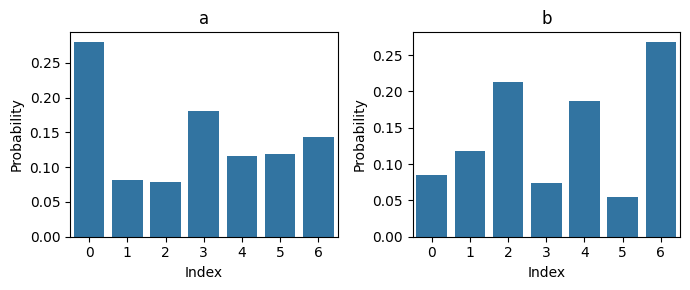

In [13]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
sns.barplot(x=np.arange(size_a), y=a)
plt.title('a')
plt.xlabel('Index')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
sns.barplot(x=np.arange(size_b), y=b)
plt.title('b')
plt.xlabel('Index')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

In [15]:
"""
C = np.array([[0, 1, 1],
              [1, 0, 1],
              [1, 1, 0]])
"""

C = np.ones((size_a, size_b)) - np.eye(size_a)

Optimal Transport Plan:
[[0.08494263 0.         0.02662367 0.         0.0440883  0.
  0.1242855 ]
 [0.         0.08138173 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.07929588 0.         0.         0.
  0.        ]
 [0.         0.         0.10742827 0.07409493 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.11555113 0.
  0.        ]
 [0.         0.03666772 0.         0.         0.02764723 0.05437666
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.14361635]]
Final Transport Cost: 0.36674069109063706


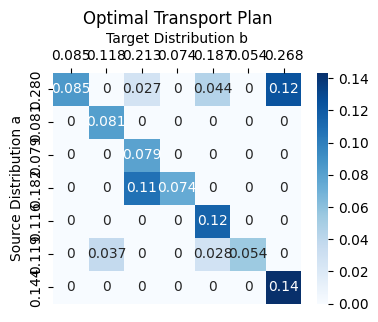

In [16]:
from scipy.optimize import linprog

# Flatten the cost matrix for the objective function
c = C.flatten()

# Equality constraints matrix A_eq and vector b_eq
# Constraints to ensure the sum of transported mass equals the probability vectors
A_eq = []
b_eq = []

# Supply constraints
for i in range(len(a)):
    constraint = np.zeros(C.shape)
    constraint[i, :] = 1
    A_eq.append(constraint.flatten())
    b_eq.append(a[i])

# Demand constraints
for j in range(len(b)):
    constraint = np.zeros(C.shape)
    constraint[:, j] = 1
    A_eq.append(constraint.flatten())
    b_eq.append(b[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Bounds for each variable (all should be non-negative)
x_bounds = [(0, None) for _ in range(len(c))]

# Solve the linear programming problem
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds, method='highs')

# Display the result
if result.success:
    optimal_transport_plan = result.x.reshape(C.shape)
    print("Optimal Transport Plan:")
    print(optimal_transport_plan)
    final_cost = np.sum(optimal_transport_plan * C)
    print("Final Transport Cost:", final_cost)
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(optimal_transport_plan, annot=True, cmap='Blues')
    current_xticks = ax.get_xticks()
    current_yticks = ax.get_yticks()
    new_xticks = [f'{b[int(tick)]:.3f}' for tick in current_xticks]
    new_yticks = [f'{a[int(tick)]:.3f}' for tick in current_yticks]
    ax.set_xticklabels(new_xticks)
    ax.set_yticklabels(new_yticks)
    plt.title("Optimal Transport Plan")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.xlabel("Target Distribution b")
    plt.ylabel("Source Distribution a")
    plt.show()
else:
    print("Optimization failed:", result.message)

In [17]:
# Total variation / ell^1 distance
ell_1 = np.sum(np.abs(a-b))
tv = ell_1 / 2
print(f"total variation distance: {tv}")

total variation distance: 0.36674069109063706


From the above transport plan, we notice that this optimal plan $\mathbf{P}^\star$ places as much mass as possible on the diagonal: for all $i \in [n]$,
$$
\mathbf{P}^\star_{ii} = \min( \mathbf{a}_i, \mathbf{b}_i)
$$

From this, we can identify $\langle \mathbf{P}^\star , \mathbf{C} \rangle$ even without specifying the optimal plan because of how $\mathbf{C}$ is defined to give cost $1$ everywhere except the diagonal.

It suffices to consider the remaining mass to be transported: after assigning the diagonal of $\mathbf{P}^\star$ as above, consider that:
* for each $i \in [n]$, the remaining mass from $\mathbf{a}_i$ to be transferred is $\mathbf{a}_i - \min ( \mathbf{a}_i, \mathbf{b}_i)$, which is equal to $\max( \mathbf{a}_i - \mathbf{b}_i, 0 )$.
* likewise, for each $j \in [n]$, the remaining mass from total $\mathbf{b}_j$ required to be transferred is $\max(\mathbf{b}_j - \mathbf{a}_j, 0)$

The transport is charged cost $1$ per unit of mass, so in total we have a cost

$$
\sum_{i=1}^n \max( \mathbf{a}_i - \mathbf{b}_i, 0) + \sum_{j=1}^n \max(\mathbf{b}_i - \mathbf{a}_i, 0) = \sum_{i=1}^n | \mathbf{a}_i - \mathbf{b}_i |,
$$

as for the two sums on the left, a term is positive if and only if its corresponding term in the other sum is zero, which allows us to mesh the two sums together into a single sum of the same length.

> I'm not sure that the transport plan needs to be unique (even if the optimal cost is unique), depending on the input measures. E.g. if the input measures are uniform, the optimal transport plan probably has a bunch of symmetries in terms of being able to shift mass around while maintaining the same ground cost.